In [1]:
from pyradio.ezone import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path

from scipy.interpolate import griddata
import rasterio
from rasterio.plot import show

pyradiodir: C:\Users\tranfa.carmine\Desktop\sensori\radio_plan\pyradio\pylayers-master
basename: C:\Users\tranfa.carmine\Desktop\sensori\radio_plan\pyradio\pylayers_project


In [2]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [3]:
def clipRaster(orig_raster, point_x, point_y, pxsize_x, pxsize_y, n_pixel = 2000):
    """Function to clip Raster data arround a point"""
    from shapely.geometry import box
    import geopandas as gpd
    from rasterio.mask import mask
    import pycrs
    lom, loM, lam, laM = (point_x-(n_pixel*pxsize_x), point_x+(n_pixel*pxsize_x), 
                        point_y-(n_pixel*pxsize_y), point_y+(n_pixel*pxsize_y))
    bbox = box(lom, lam, loM, laM)
    box = [lom, loM, lam, laM]
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
    geo = geo.set_crs(4326)
    coords = getFeatures(geo)
    with rasterio.open(orig_raster) as data:
        out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
        out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                      "height": out_img.shape[1],
                      "width": out_img.shape[2],
                      "transform": out_transform,
                      "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                   )
    out_tif = orig_raster.replace('.tif','_clip.tif')
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)
    
    return out_tif, box

In [4]:
path_dem = '_dem/dem_10m_4326.tif'

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 10086, 'height': 15395, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00012663418669442788, 0.0, 9.616337271,
       0.0, -8.864314004546925e-05, 44.702084875)}
Max/Min: 2162.684 -3.4028235e+38


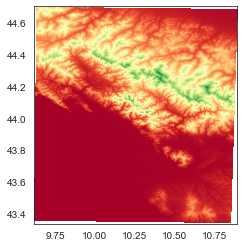

In [5]:
dem_gaia = rasterio.open(path_dem)

print(dem_gaia.meta)
pixelsize_lon, pixelsize_lat = dem_gaia.meta['transform'][0], -dem_gaia.meta['transform'][4]
print('Max/Min:', dem_gaia.read(1).max(), dem_gaia.read(1).min())
show(dem_gaia, cmap='RdYlGn')

dem_gaia.close()

In [6]:
# ######## Script di test ###########

# latgw = 43.9131163082
# longw = 10.2951162022

# n_pixel = 1000

# lom, loM, lam, laM = (longw-(n_pixel*pixelsize_lon), longw+(n_pixel*pixelsize_lon), 
#                     latgw-(n_pixel*pixelsize_lat), latgw+(n_pixel*pixelsize_lat))
# bbox = box(lom, lam, loM, laM)
# geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
# geo = geo.set_crs(4326)
# # print(geo.crs)
# coords = getFeatures(geo)
# data = rasterio.open(path_dem)
# # print('Min/Max Originale:', data.read(1).min(), data.read(1).max())
# out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
# out_meta = data.meta.copy()
# data.close()
# epsg_code = int(data.crs.data['init'][5:])
# # print(epsg_code)
# out_meta.update({"driver": "GTiff",
#                   "height": out_img.shape[1],
#                   "width": out_img.shape[2],
#                   "transform": out_transform,
#                   "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
#                )

# out_tif = 'pyradio/dem_10m_4326.tif'.replace('4326','4326_clip')
# with rasterio.open(out_tif, "w", **out_meta) as dest:
#     dest.write(out_img)

# dem_clip = rasterio.open(out_tif)
# # print('Min/Max Clip:', dem_clip.read(1).min(), dem_clip.read(1).max())
# show(dem_clip, cmap='RdYlGn')
# dem_clip.close()

# dem=DEM(enctile(longw,latgw))
# dem.loadraster(fileraster=out_tif, box = [lom, loM, lam, laM])

# xgw, ygw = dem.m(longw, latgw)

# ez = Ezone(enctile(longw, latgw))
# ez.extent = dem.extent
# ez.pll = ez.m(ez.extent[0], ez.extent[2])
# ez.pur = ez.m(ez.extent[1], ez.extent[3])
# ez.hgts=dem.hgts
# ez.rebase()

# pa = np.array([longw,latgw])

# L1 = ez.cover(pc=pa, Ht=12, Hr=0, Nr=100, Rmax=8000, method='deygout',
#         source='srtm', fGHz=0.868)

# ez.showcov(L1[0],-L1[1].flatten())
# print('Min:', -L1[1].flatten().min())
# print('Max:', -L1[1].flatten().max())

## Impianto AI VENTI

Lowered zoom level to keep map size reasonable. (z = 11)


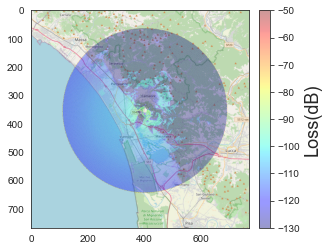

In [7]:
latgw = 43.9131163082
longw = 10.2951162022

out_path, clip_box = clipRaster(path_dem, longw, latgw, pixelsize_lon, pixelsize_lat)

dem=DEM(enctile(longw, latgw))
dem.loadraster(fileraster = out_path, box = clip_box)
ez = Ezone(enctile(longw, latgw))
ez.extent = dem.extent
ez.pll = ez.m(ez.extent[0], ez.extent[2])
ez.pur = ez.m(ez.extent[1], ez.extent[3])
ez.hgts=dem.hgts
ez.rebase()

pa = np.array([longw,latgw])

L1 = ez.cover(pc=pa, Ht=12, Hr=0, Nr=200, Rmax=16000, method='deygout', fGHz=0.868)

ez.showcov(L1[0],-L1[1].flatten())

## Elenco Impianti

In [8]:
work_path = Path(os.getcwd())
work_path = work_path.parent
work_path

WindowsPath('C:/Users/tranfa.carmine/Desktop/sensori/radio_plan')

In [9]:
excel_path = os.path.join(work_path,'impianti_gaia.xlsx')

df_impianti = pd.read_excel(excel_path)

df_impianti['comune'] = df_impianti['location'].str[:2]
df_impianti['servizio'] = df_impianti['location'].str[2:3]
df_impianti['tipo'] = df_impianti['location'].str[5:6]

df_impianti = df_impianti.loc[ (df_impianti['comune'].isin(['07','10','27','31','44','42','35','20','49','28'])) 
                              & (df_impianti['tipo']!='O') 
                              & (df_impianti['tipo']!='A') ].copy()


df_impianti = df_impianti.loc[ (df_impianti['tipo']!='O') 
                              & (df_impianti['tipo']!='A') ].copy()

df_impianti.shape[0], df_impianti.head(3)

(1073,
      location                     description  longitudex  latitudey comune  \
 631  07A01E01  Pompaggio FRATI - MONTE DONAIA   10.292225  43.937502     07   
 632  07A01E02      Pompaggio TENERI CARIGNONI   10.299586  43.937374     07   
 633  07A01E03          Pompaggio PRIMO MOLINO   10.288706  43.937830     07   
 
     servizio tipo  
 631        A    E  
 632        A    E  
 633        A    E  )

### Legenda parametri

pc : np.array
     center point in lonlat coordinates
Nphi : int
     Number of angular direction
Nr : int
     Number of points along radius
Rmax : float
     Radius maximum (meters)
Hr : float
     Receiver height
Ht : float
     Transmitter height
K : float
     K factor

In [10]:
Nr = 200
Rmax = 16000
Ht = 12
Hr = 0
fGHz = 0.868

In [11]:
###### Escludo gli impianti già processati
raster_path = os.path.join(work_path,'raster')

impianti_proc = [f[:-4] for f in listdir(raster_path) if isfile(join(raster_path, f))]

df_impianti = df_impianti.loc[~df_impianti['location'].isin(impianti_proc)].copy()
df_impianti

,location,description,longitudex,latitudey,comune,servizio,tipo


In [12]:
export = True

for index, i in df_impianti.iterrows():
    try:
        latgw = i['latitudey']
        longw = i['longitudex']
        out_path, clip_box = clipRaster(path_dem, longw, latgw, pixelsize_lon, pixelsize_lat)

        dem=DEM(enctile(longw, latgw))
        dem.loadraster(fileraster = out_path, box = clip_box)
        ez = Ezone(enctile(longw, latgw))
        ez.extent = dem.extent
        ez.pll = ez.m(ez.extent[0], ez.extent[2])
        ez.pur = ez.m(ez.extent[1], ez.extent[3])
        ez.hgts=dem.hgts
        ez.rebase()

        pa = np.array([longw,latgw])

        L1 = ez.cover(pc=pa, Ht=Ht, Hr=Hr, Nr=Nr, Rmax=Rmax, method='deygout', fGHz=fGHz)
        print(i['location']+" - "+i['description'])
        ez.showcov(L1[0],-L1[1].flatten())
        plt.show()

        if export:
            x = L1[0].x
            y = L1[0].y
            points = list(zip(x,y))
            values = -L1[1].flatten()
            xRes = (x.max() - x.min()) / Nr
            yRes = (y.max() - y.min()) / Nr
            xRange = np.arange(x.min(),x.max()+xRes,xRes)
            yRange = np.arange(y.min(),y.max()+yRes,yRes)
            gridX,gridY = np.meshgrid(xRange, yRange)
            grid_dB = griddata(points, values, (gridX,gridY), method='linear')
            transform = rasterio.transform.Affine.translation(gridX[0][0]-xRes/2, gridY[0][0]-yRes/2)*rasterio.transform.Affine.scale(xRes,yRes)
            new_dataset = rasterio.open(
                'raster/' + i['location'] + '.tif',
                'w',
                driver='GTiff',
                height=grid_dB.shape[0],
                width=grid_dB.shape[1],
                count=1,
                dtype=grid_dB.dtype,
                crs='+proj=latlong',
                transform=transform,
            )
            new_dataset.write(grid_dB, 1)
            new_dataset.close()
    except Exception as e:
        print("Errore: ", e)

### Export Raster

In [13]:
# x = L1[0].x
# y = L1[0].y

# points = list(zip(x,y))
# values = -L1[1].flatten()

# xRes = (x.max() - x.min()) / Nr
# yRes = (y.max() - y.min()) / Nr


# xRange = np.arange(x.min(),x.max()+xRes,xRes)
# yRange = np.arange(y.min(),y.max()+yRes,yRes)

# gridX,gridY = np.meshgrid(xRange, yRange)

# #interpolate over the grid
# grid_dB = griddata(points, values, (gridX,gridY), method='linear')

# #show interpolated values
# # plt.imshow(grid_dB, cmap='viridis')

In [14]:
# transform = rasterio.transform.Affine.translation(gridX[0][0]-xRes/2, gridY[0][0]-yRes/2)*rasterio.transform.Affine.scale(xRes,yRes)
# transform

In [15]:
# new_dataset = rasterio.open(
#     'prova.tif',
#     'w',
#     driver='GTiff',
#     height=grid_dB.shape[0],
#     width=grid_dB.shape[1],
#     count=1,
#     dtype=grid_dB.dtype,
#     crs='+proj=latlong',
#     transform=transform,
# )

# new_dataset.write(grid_dB, 1)
# new_dataset.close()

In [16]:
# new_dataset.close()

### Best LoRa Spots

In [17]:
rasters = [f for f in listdir(raster_path) if isfile(join(raster_path, f))]

rasters

['07A01E01.tif',
 '07A01E02.tif',
 '07A01E03.tif',
 '07A01E04.tif',
 '07A01E05.tif',
 '07A01E06.tif',
 '07A01E07.tif',
 '07A01E08.tif',
 '07A01E09.tif',
 '07A01H01.tif',
 '07A01H02.tif',
 '07A01H03.tif',
 '07A01H04.tif',
 '07A01H05.tif',
 '07A01P01.tif',
 '07A02H01.tif',
 '07A03E01.tif',
 '07A03E02.tif',
 '07A03E03.tif',
 '07A03H01.tif',
 '07A03H02.tif',
 '07A03H03.tif',
 '07A03H04.tif',
 '07A03H05.tif',
 '07A03H06.tif',
 '07A03H07.tif',
 '07A03S01.tif',
 '07A03S02.tif',
 '07A03S03.tif',
 '07A03S04.tif',
 '07A03S05.tif',
 '07A03S06.tif',
 '07A03S07.tif',
 '07A03S08.tif',
 '07A03S09.tif',
 '07A03S10.tif',
 '07A04E01.tif',
 '07A04E02.tif',
 '07A04H01.tif',
 '07A04P01.tif',
 '07A05H02.tif',
 '07A05S01.tif',
 '07A05S02.tif',
 '07A05S03.tif',
 '07A05S04.tif',
 '07A05S05.tif',
 '07A06H01.tif',
 '07A07E01.tif',
 '07A07E02.tif',
 '07A07E04.tif',
 '07A07E05.tif',
 '07A07E06.tif',
 '07A07E07.tif',
 '07A07H01.tif',
 '07A07H02.tif',
 '07A07H03.tif',
 '07A07H04.tif',
 '07A07H05.tif',
 '07A07H06.tif

In [18]:
list_dB = []

for raster_name in rasters:
    with rasterio.open(raster_path+'/'+raster_name) as raster:
        print(raster_name)
        array = raster.read(1)
        dB = array.copy() > -110
        dB_cover = dB.sum()/(dB.shape[0]*dB.shape[1])
        print(dB_cover)
        list_dB.append([raster_name, dB_cover, array])
        #plt.imshow(array, cmap='CMRmap_r', vmin=-110, vmax=-50 )
        #plt.show()

df_dB = pd.DataFrame(list_dB, columns = ['raster_name','dB_cover', 'array'])
df_dB

07A01E01.tif
0.021385609267097348
07A01E02.tif
0.02428157718868345
07A01E03.tif
0.020023644155460322
07A01E04.tif
0.026451898921235405
07A01E05.tif
0.1042805773114625
07A01E06.tif
0.015684736790510734
07A01E07.tif
0.02551598443426432
07A01E08.tif
0.02328203117341437
07A01E09.tif
0.02667356287867593
07A01H01.tif
0.10248263632333382
07A01H02.tif
0.04445434518947551
07A01H03.tif
0.02724003743657948
07A01H04.tif
0.02352100881729964
07A01H05.tif
0.026657755996138708
07A01P01.tif
0.021591020488187434
07A02H01.tif
0.06578493670262549
07A03E01.tif
0.007351303185564714
07A03E02.tif
0.036746958277917345
07A03E03.tif
0.017130673463385943
07A03H01.tif
0.036746958277917345
07A03H02.tif
0.011428008472489039
07A03H03.tif
0.007241022609723659
07A03H04.tif
0.008724634839721596
07A03H05.tif
0.020049008687903765
07A03H06.tif
0.011181715186444018
07A03H07.tif
0.010668052770971015
07A03S01.tif
0.010989826984480582
07A03S02.tif
0.013102802817595193
07A03S03.tif
0.010611704734829919
07A03S04.tif
0.0101719127

0.02063937737057288
10A10S04.tif
0.01923219722284102
10A10S05.tif
0.014777597162701345
10A10S06.tif
0.012807250874341165
10A11H01.tif
0.008521747697157776
10A11S01.tif
0.008472489039948771
10A12E01.tif
0.008896186648367808
10A12E02.tif
0.007180668561905696
10A12E03.tif
0.014679079848283335
10A12H01.tif
0.018718289739421703
10A12H02.tif
0.0142633075188707
10A12H03.tif
0.007068617309492143
10A12S01.tif
0.039628467797274775
10A12S02.tif
0.009925497500245075
10A12S03.tif
0.009654696812964879
10A12S04.tif
0.007033624154494657
10A12S05.tif
0.00714250529530565
10A12S06.tif
0.007191763952514654
10A13E01.tif
0.009975000618796564
10A13H01.tif
0.010643300908393357
10A13N01.tif
0.010590611299935963
10A13P01.tif
0.00850406822860504
10A13S01.tif
0.008044355337739164
10A13S02.tif
0.007156161160670522
10A14E01.tif
0.025757278698166845
10A14H01.tif
0.025885424363331855
10A14H02.tif
0.01727680007920596
10A14S01.tif
0.00800453179646323
10A14S02.tif
0.024752475247524754
10A14S03.tif
0.024998768533569776
1

0.04994827840993055
27F02Q84.tif
0.04053987488301069
27F02Q87.tif
0.04938180385202699
27F03D01.tif
0.041180237426727745
27F03Q27.tif
0.0528452266033019
27F03Q28.tif
0.052263435298753755
27F03Q29.tif
0.051195961180276445
27F03Q30.tif
0.052127422588549785
27F03Q31.tif
0.05215217445112745
27F03Q33.tif
0.050295784757803025
27F03Q34.tif
0.051211603673176405
27F03Q35.tif
0.048864587951332444
27F03Q37.tif
0.04268262647160238
27F03Q38.tif
0.05086507759708918
27F03Q39.tif
0.05034234766760258
27F03Q43.tif
0.03928536417998235
27F03Q44.tif
0.03593419043396877
27F03Q45.tif
0.0340623614600266
27F03Q49.tif
0.043987980887641005
27F03Q52.tif
0.04176061170473483
27F03Q53.tif
0.04053524164297618
27F03Q54.tif
0.039973400325107135
27F03Q55.tif
0.04514555933205261
27F03Q56.tif
0.043917263013430054
27F03Q60.tif
0.034900126234499146
27F03Q86.tif
0.04090285266150377
27F03Q88.tif
0.040736909511846706
27F03Q89.tif
0.04196837594207182
27F03Q90.tif
0.03659918230629033
27F04D01.tif
0.03960298012425435
27F05D01.tif


0.038158023723164396
35F03Q14.tif
0.013062444858347221
35F03Q15.tif
0.03790453672232895
35F03Q16.tif
0.012945224128115641
42A01E01.tif
0.011625043101325058
42A01E02.tif
0.01933402295453426
42A01H01.tif
0.019504467711195267
42A01H02.tif
0.020296527313680354
42A01H03.tif
0.01159200078423684
42A01S01.tif
0.011322419370649936
42A01S02.tif
0.011420448975590629
42A01S03.tif
0.011181715186444018
42A02E02.tif
0.010836904585980986
42A02P01.tif
0.027634106694251516
42A02P02.tif
0.03281541025389668
42A02P03.tif
0.03359964709342221
42A02P04.tif
0.03336551075468429
42A03H01.tif
0.009088222255061326
42A03S01.tif
0.009606901284187825
42A04E01.tif
0.021279739914289938
42A04E02.tif
0.033266503304373654
42A04H01.tif
0.03310181764445101
42A04H02.tif
0.07288501127340456
42A04S01.tif
0.018964583025466726
42A04S02.tif
0.02091532387812183
42A05E02.tif
0.009529467092398703
42A05E03.tif
0.007339539924141668
42A05E04.tif
0.029382789025171174
42A05E05.tif
0.02544491472983342
42A05E06.tif
0.012106656210175473
42A

0.03421233212430154
49F03Q29.tif
0.033984307319125766
49F03Q30.tif
0.033281050877364965
49F03Q31.tif
0.03480111878418851
49F03Q32.tif
0.032806265701196984
49F03Q38.tif
0.034998275946997684
49F03Q40.tif
0.03558937983350574
49F03Q52.tif
0.03438033712036831
49F04Q11.tif
0.03543770218606019


,raster_name,dB_cover,array
0,07A01E01.tif,0.021386,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,07A01E02.tif,0.024282,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,07A01E03.tif,0.020024,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,07A01E04.tif,0.026452,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,07A01E05.tif,0.104281,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
...,...,...,...
1068,49F03Q32.tif,0.032806,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1069,49F03Q38.tif,0.034998,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1070,49F03Q40.tif,0.035589,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1071,49F03Q52.tif,0.034380,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


In [24]:
exelout_path = os.path.join(work_path,'radio_cover.xlsx')

df_dB[['raster_name','dB_cover']].to_excel(exelout_path)

0.0504871973823657


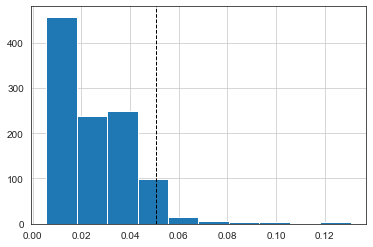

In [20]:
dB_cover85 = df_dB['dB_cover'].quantile(0.95)
print(dB_cover85)

df_dB['dB_cover'].hist()
plt.axvline(dB_cover85, color='k', linestyle='dashed', linewidth=1)
plt.show()

07A01E05.tif


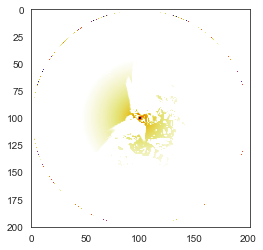

07A01H01.tif


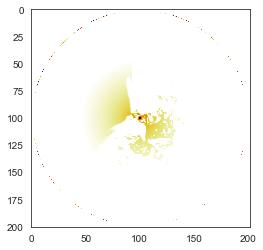

07A02H01.tif


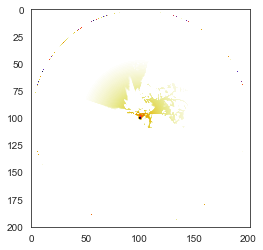

07A06H01.tif


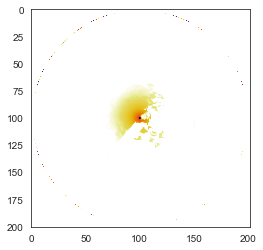

07F03Q05.tif


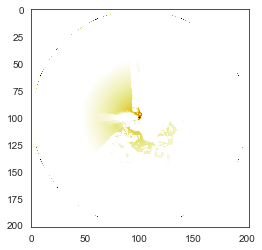

10A03H02.tif


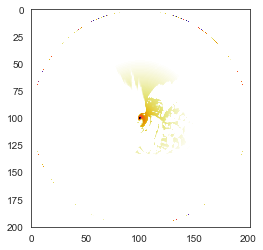

10A04H02.tif


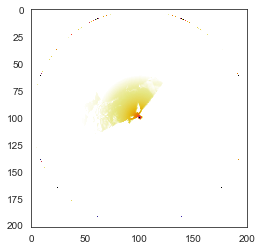

10A04S01.tif


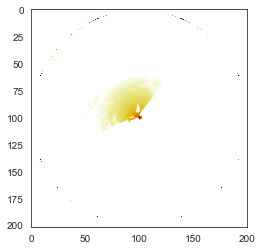

10A04S02.tif


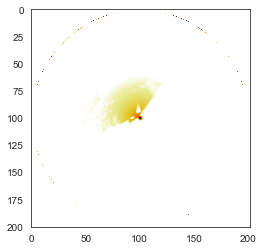

10F04D01.tif


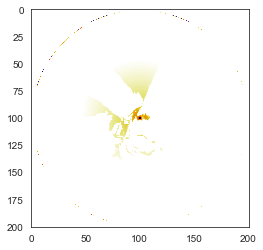

27A06H08.tif


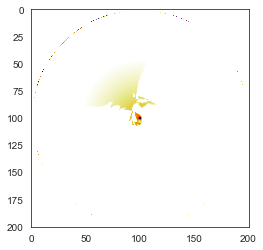

27A06H10.tif


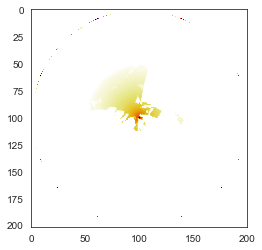

27A09H01.tif


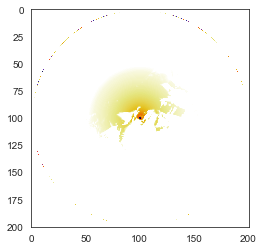

27A09H16.tif


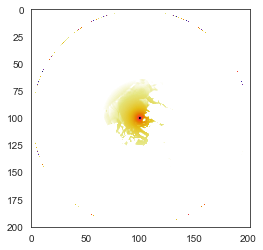

27A10E01.tif


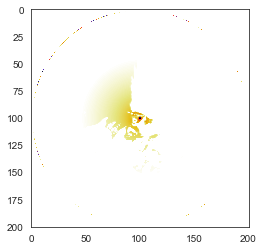

27A10H03.tif


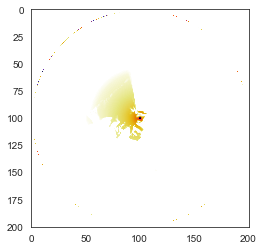

27A10H17.tif


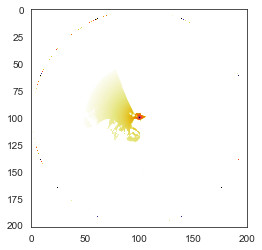

27A10H18.tif


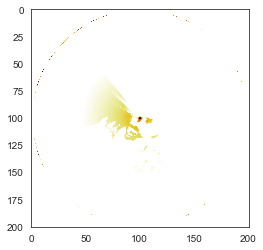

27A10S29.tif


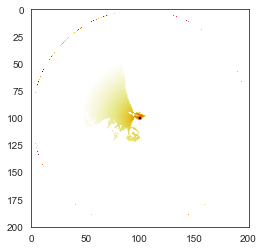

27F01Q02.tif


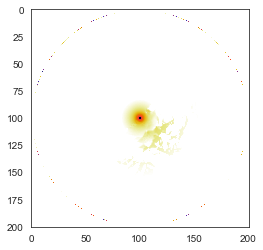

27F01Q03.tif


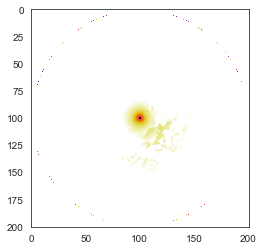

27F01Q04.tif


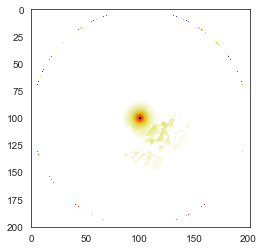

27F01Q46.tif


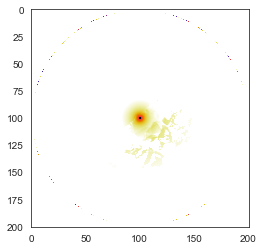

27F03Q27.tif


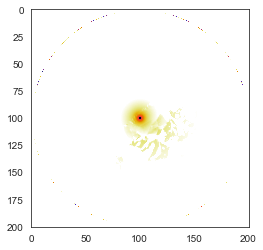

27F03Q28.tif


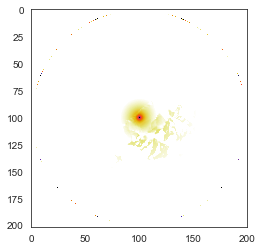

27F03Q29.tif


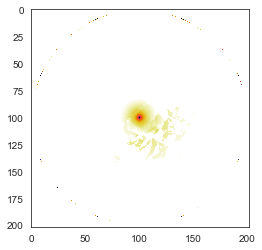

27F03Q30.tif


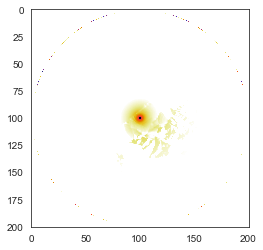

27F03Q31.tif


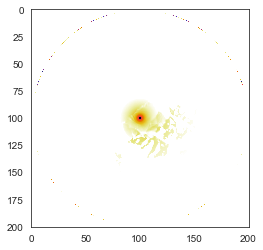

27F03Q34.tif


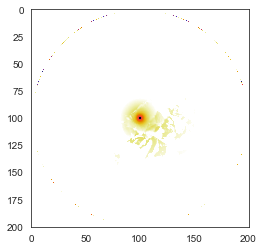

27F03Q38.tif


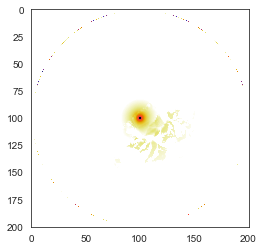

28A01E16.tif


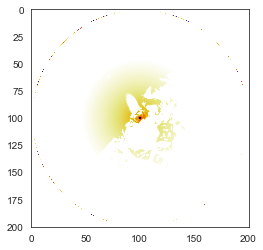

28A01E17.tif


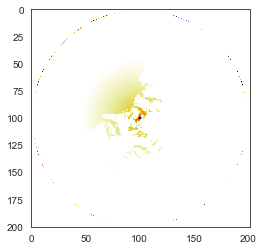

28A01H07.tif


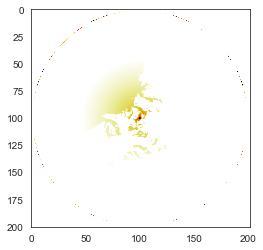

28A01H10.tif


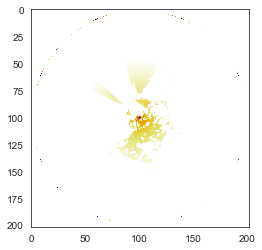

28A01H11.tif


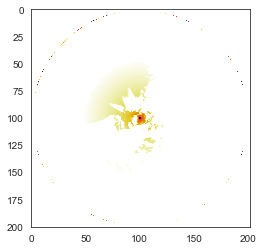

28A01H13.tif


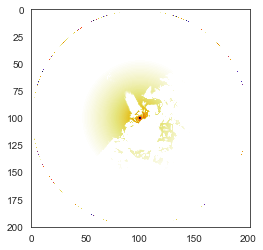

28F01Q21.tif


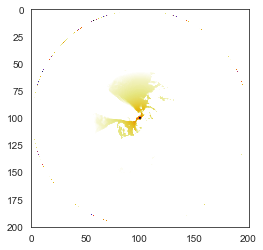

28F03Q01.tif


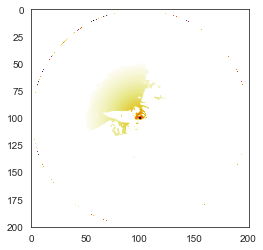

31A03H01.tif


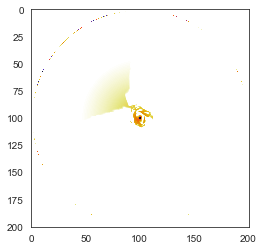

31A03H02.tif


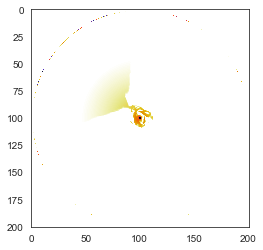

31A04H01.tif


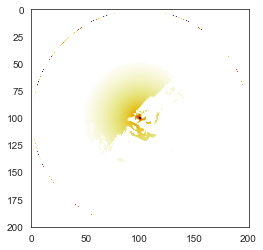

31A04H02.tif


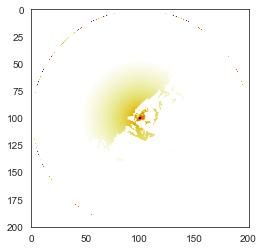

35A01E05.tif


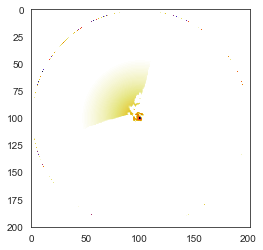

35A01H03.tif


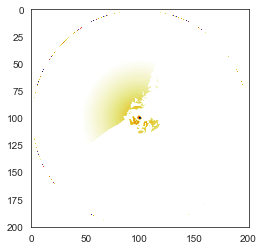

35A05H02.tif


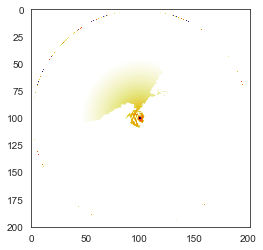

35F03Q01.tif


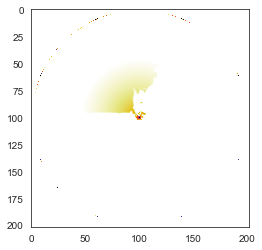

42A04H02.tif


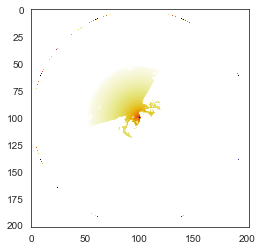

42A99S01.tif


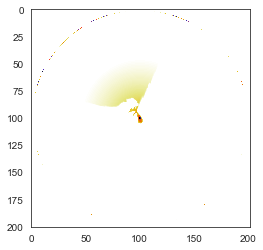

42A99S02.tif


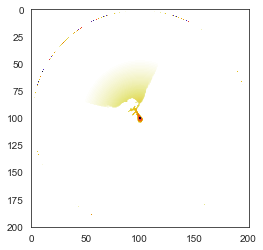

42A99S03.tif


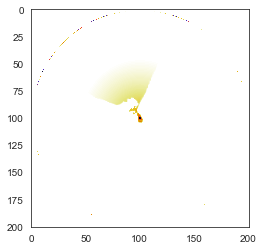

42A99S04.tif


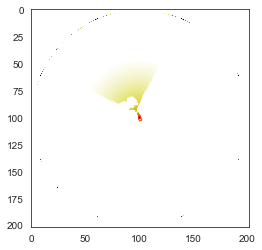

42A99S05.tif


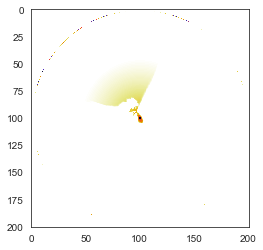

44A01H01.tif


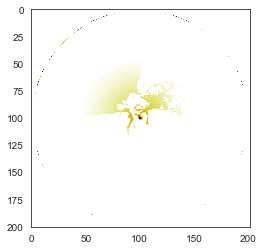

44A03H01.tif


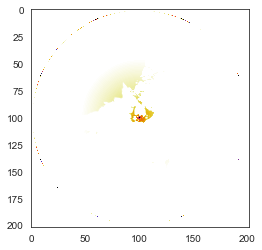

In [21]:
df_dB_best = df_dB.loc[df_dB['dB_cover']>dB_cover85].copy()
df_dB_best

for b in df_dB_best['raster_name']:
    print(b)
    plt.imshow(df_dB['array'].loc[df_dB['raster_name']==b].iloc[0], cmap='CMRmap_r', vmin=-110, vmax=-50 )
    plt.show()

In [22]:
df_dB_best

,raster_name,dB_cover,array
4,07A01E05.tif,0.104281,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
9,07A01H01.tif,0.102483,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
15,07A02H01.tif,0.065785,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
46,07A06H01.tif,0.050515,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
142,07F03Q05.tif,0.095285,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
221,10A03H02.tif,0.060071,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
224,10A04H02.tif,0.057977,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
225,10A04S01.tif,0.058347,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
226,10A04S02.tif,0.057411,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
348,10F04D01.tif,0.054924,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
